In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa 
#import librosa.display
from IPython.display import Audio
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
plt.style.use('ggplot')

In [2]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('Emotions/input/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())



In [3]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
5764,Emotions/input/Fearful/1070_IEO_FEA_MD.wav,fearful.wav
12352,Emotions/input/Disgusted/OAF_chalk_disgust.wav,disgusted.wav
6541,Emotions/input/Neutral/1026_IEO_NEU_XX.wav,neutral.wav
9971,Emotions/input/Angry/1045_TSI_ANG_XX.wav,angry.wav
11326,Emotions/input/Disgusted/1055_DFA_DIS_XX.wav,disgusted.wav
11451,Emotions/input/Disgusted/1077_IEO_DIS_LO.wav,disgusted.wav
9051,Emotions/input/Angry/1036_WSI_ANG_XX.wav,angry.wav
8228,Emotions/input/Angry/1041_TIE_ANG_XX.wav,angry.wav
898,Emotions/input/Happy/1052_IWW_HAP_XX.wav,happy.wav
8670,Emotions/input/Angry/1039_TIE_ANG_XX.wav,angry.wav


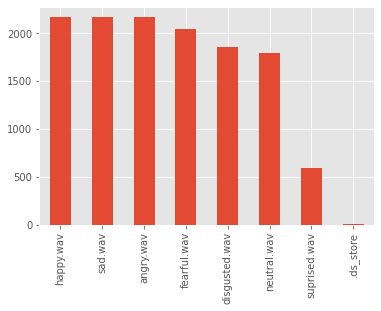

In [4]:
data['label'].value_counts().plot(kind='bar');

In [14]:
import librosa.display

def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    
def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    Audio(path)

In [20]:
data = data[data.label.apply(lambda x: x != '.ds_store')]

In [34]:
data['label'].unique().tolist()

['happy.wav',
 'sad.wav',
 'fearful.wav',
 'neutral.wav',
 'angry.wav',
 'suprised.wav',
 'disgusted.wav']

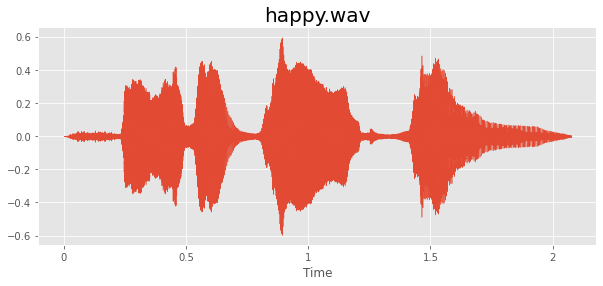

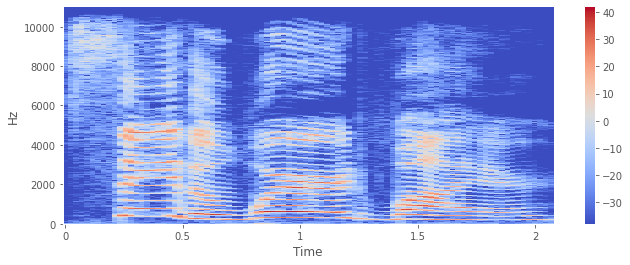

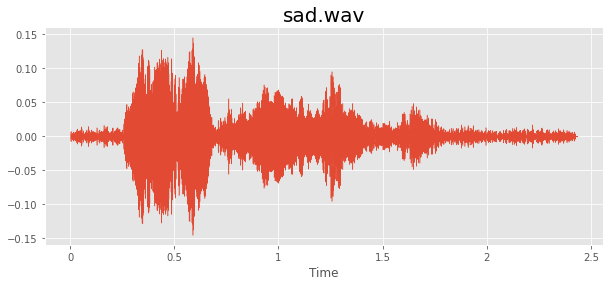

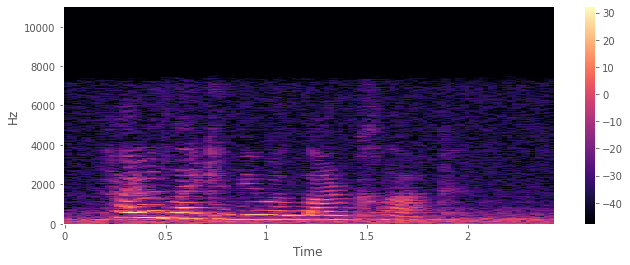

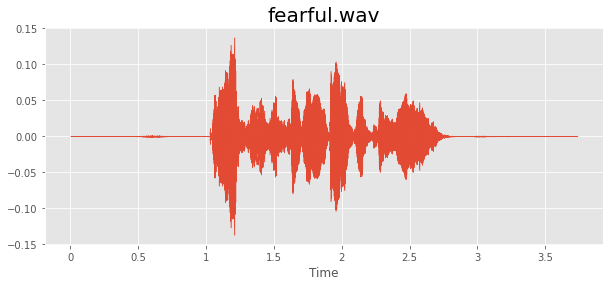

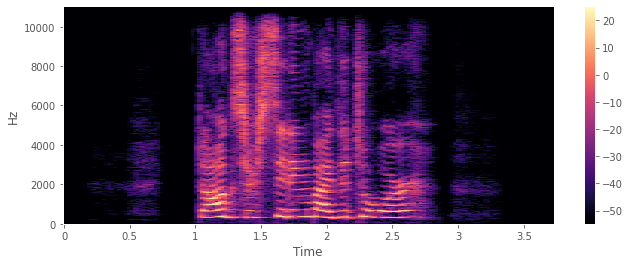

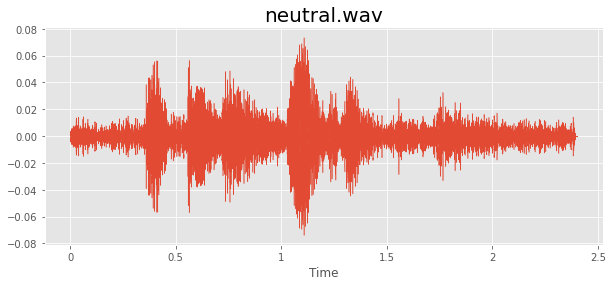

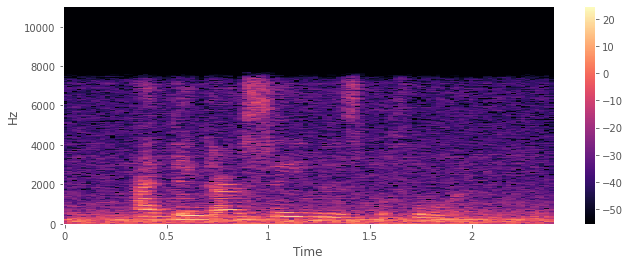

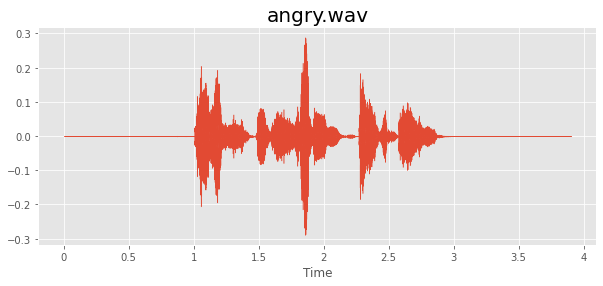

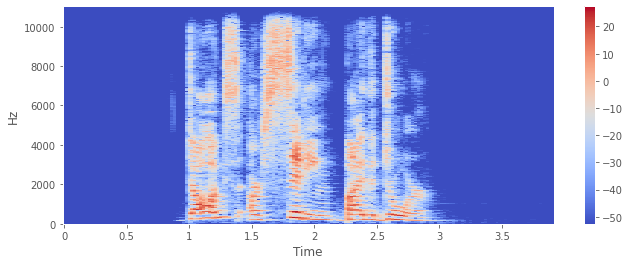

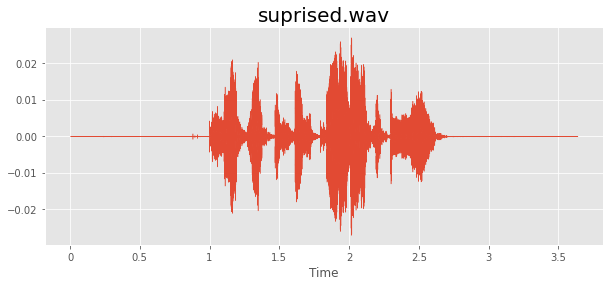

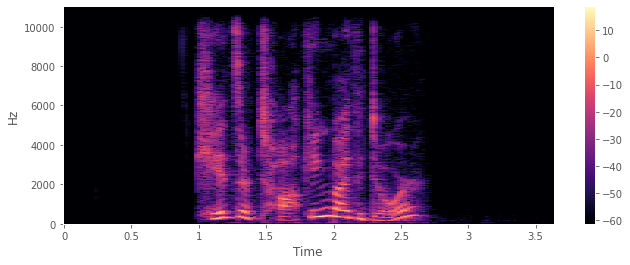

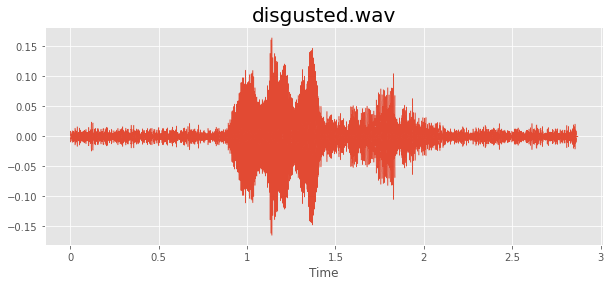

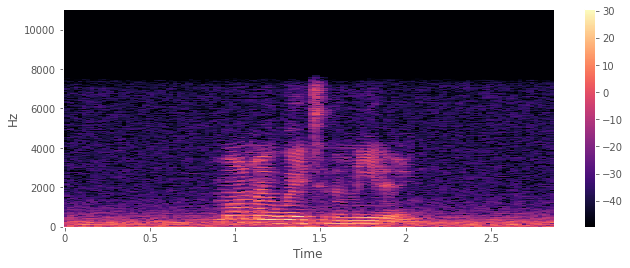

In [35]:
for i in data['label'].unique().tolist(): # ver uno de cada sentimiento
    ana_emotion(i,data)

In [36]:
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [37]:
mfcc

1        [-296.8756, 66.352974, -39.55309, 18.75589, -1...
2        [-438.26196, 46.323425, -21.993301, 13.925345,...
3        [-470.7807, 123.568886, 21.59158, -17.209415, ...
4        [-351.44592, 119.26234, 8.294701, 48.96955, -1...
5        [-412.51575, 34.781128, -55.72327, 11.081317, ...
                               ...                        
12794    [-440.24832, 156.82884, 5.6261573, 66.09786, -...
12795    [-454.3073, 111.52253, 24.979279, 3.5972264, 1...
12796    [-339.35837, 126.01156, -7.6588516, 54.669884,...
12797    [-396.72943, 149.69432, -5.798008, 67.7116, -3...
12798    [-472.56873, 106.1529, 10.005315, -5.124029, 1...
Name: speech, Length: 12798, dtype: object

Loading YAMNet from TensorFlow Hub

In [42]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_io as tfio

ModuleNotFoundError: No module named 'tensorflow_io'

In [40]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [41]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

229376/215546 [===============================] - 0s 1us/step
./test_data/miaow_16k.wav


In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav